In [1]:
#To register MainEnvRL with local copy of Gym
"""
from gym.envs.registration import register
 
register(
    id='MainEnvRL-v2',
    #entry_point='balance_bot.envs:BalancebotEnv',
    entry_point='MainEnv_RL.envs:MainEnvRL',
)

"""
#import gym
#for env in gym.envs.registry.env_specs:
#    print(env)
    
    #if 'MainEnvRL-v1' == env:
    #     print('Remove {} from registry'.format(env))
         #del gym.envs.registry.env_specs[env]
            
            
#import MainEnv_RL

#env = gym.make('MainEnvRL-v2')
#env.reset()
"""
for env in gym.envs.registry.env_specs:
     if 'MainEnvRL-v0' in env:
        print('Remove {} from registry'.format(env))
        del gym.registry.env_specs[env]
"""                


"\nfor env in gym.envs.registry.env_specs:\n     if 'MainEnvRL-v0' in env:\n        print('Remove {} from registry'.format(env))\n        del gym.registry.env_specs[env]\n"

## Train the policy

Ep: 20   Total Steps taken: 570


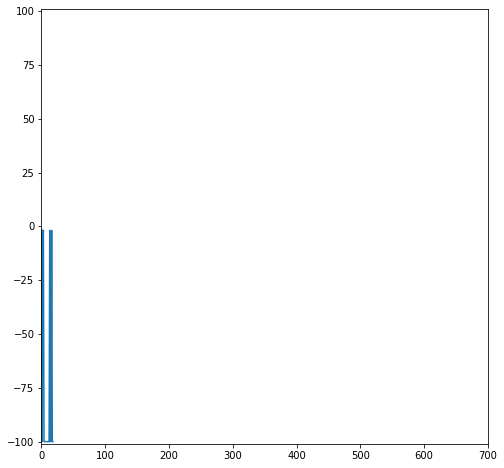

---------------------------------------
| approxkl           | 0.0023683954   |
| clipfrac           | 0.05           |
| explained_variance | 5.96e-08       |
| fps                | 0              |
| n_updates          | 19             |
| policy_entropy     | 1.0420827      |
| policy_loss        | -0.00025040904 |
| serial_timesteps   | 570            |
| time_elapsed       | 769            |
| total_timesteps    | 570            |
| value_loss         | 55842.266      |
---------------------------------------
Ep: 20  tStep: 1 Z difference 0.0026681306183338194  Reward: -1.9973318693816662
Ep: 20  tStep: 2 Z difference -0.0018850859079506677  Reward: -2.0018850859079507
Ep: 20  tStep: 3 Z difference -0.001199866786971704  Reward: -2.0011998667869717
Ep: 20  tStep: 4 Z difference 0.048722276799753494  Reward: -1.9512777232002465
Ep: 20  tStep: 5 Z difference 0.05390673970803617  Reward: -1.9460932602919638
Ep: 20  tStep: 6 Z difference 0.05143939354531479  Reward: -1.948560606454685

KeyboardInterrupt: 

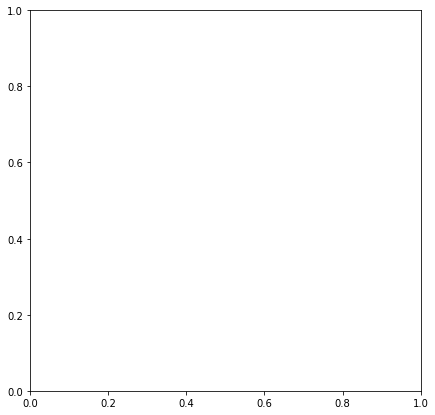

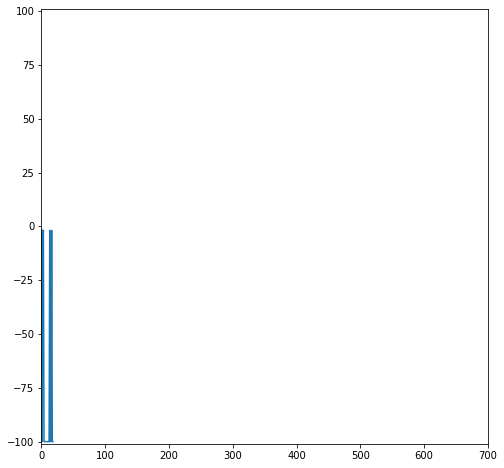

In [1]:
#https://github.com/ZhizhenQin/BalancingBot/blob/master/balance-bot/balance_bot/balancebot_task.py


#%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


import gym
from stable_baselines import DQN, PPO2
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines.common.policies import FeedForwardPolicy, register_policy,LstmPolicy
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.env_checker import check_env
from datetime import date
import csv
#import balance_bot
import socket
import numpy as np
from time import sleep
import UR5_RL

HOST_SnS = '192.168.0.103'
PORT_SnS= 65499



try:
    # Create a TCP/IP socket
    sock_SnS = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    #sock_SnS.setblocking(False)
    # Connect the socket to the port where the server is listening
    server_address_SnS = (HOST_SnS, PORT_SnS)
    print('connecting to {} port {}'.format(*server_address_SnS))
    sock_SnS.connect(server_address_SnS)


    #def callback(lcl, glb):
         #stop training if reward exceeds 199
    #    is_solved = lcl['t'] > 1000 and sum(lcl['episode_rewards'][-101:-1]) / 100 >= 1
    #    return is_solved

    #https://stable-baselines.readthedocs.io/en/master/guide/custom_policy.html
    #Layers of 20 and 15

    #Do this only after restarting the notebook!! 
    #register_policy('ScottLSTMPolicy', ScottLSTMPolicy)    
    #print("lstm registered")

    #try:
    
    #code stopped at ep 36 at 10steps per ep, 80 ep
    StepsPerEpisode=30 #was 10
    TotalEpisodes=700  #was 80
    env= gym.make("ur5-rl-v0",StepsPerEpisode=StepsPerEpisode,TotalEpisodes=TotalEpisodes,
                 continuousactionspace=False)
    env = DummyVecEnv([lambda: env])

    timesteps=(StepsPerEpisode*TotalEpisodes)
    print("Total timesteps:",timesteps)
    
    class ScottLSTMPolicy(LstmPolicy):
        def __init__(self, sess, ob_space, ac_space, n_env=1, n_steps=StepsPerEpisode,
                     n_batch=StepsPerEpisode, n_lstm=StepsPerEpisode, reuse=False,  **_kwargs):
            super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, reuse,
                             net_arch=[7,'lstm',dict(vf=[20, 15],pi=[20,15])],
                             layer_norm=True, feature_extraction="mlp", **_kwargs)
            
    #model = DQN("LnMlpPolicy", env, learning_rate=1e-3, prioritized_replay=True,gamma=1 , buffer_size=50000,param_noise=False,
    # exploration_initial_eps=0.1, exploration_final_eps=0.1,learning_starts=1, verbose=1)


    #model = PPO2("MlpPolicy", env,verboThe new research shows that "we must expect extreme event records to be broken - not just by small marse=0)
    #model = PPO2("MlpLstmPolicy", env,nminibatches=1, n_steps=80, #exploration_initial_eps=1, exploration_final_eps=0.1,
    #             verbose=0,tensorboard_log="./ScottPPOLstm/") #n_lstm=2, n_batch=80, nminibatches=10,

    model = PPO2(ScottLSTMPolicy, env,nminibatches=1, n_steps=StepsPerEpisode,learning_rate=0.1,
                 verbose=2)
    
    # DEFAULT learning_rate=0.00025  #n_lstm=2, n_batch=80, nminibatches=10,
    ##exploration_initial_eps=1, exploration_final_eps=0.1,

    #model.learn(total_timesteps=timesteps,b_log_name="first_run", reset_num_timesteps=False)#50000
    model.learn(total_timesteps=timesteps,reset_num_timesteps=False)#50000
    
    today = date.today()
    todaydate = today.strftime("%m_%d_%Y")
    RLmodelfilename="UR5-RL_savedpolicy_"+todaydate
    model.save(RLmodelfilename)# save trained model
    
    del model
    print("training complete")
    

finally:
    endmsg='end'
    data1=endmsg.encode('ascii')    
    sock_SnS.sendall(data1)
    sock_SnS.sendall(data1)
    print('closing SnS socket')
    sock_SnS.close()
    
    HOST2 = '192.168.0.103'
    PORT2= PORT_SnS-10 #65481
    sock_DC = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_address_DC = (HOST2, PORT2)
    sock_DC.close()
    print("socket DC Closed")
      
    #gitkraken
    
    #check_env(env)
    #https://stable-baselines.readthedocs.io/en/master/modules/dqn.html
    #model.learn(total_timesteps=25000)
    #del model # remove to demonstrate saving and loading
    #model = DQN.load("deepq_cartpole")

    
    #Starting at 11:02AM
    #80 episodes in 45 min


In [2]:
model.save("UR5-RL_savedpolicy-8-5to6-2021")
print("saved!")

saved!


In [ ]:
HOST2 = '192.168.0.103'learning_rate=0.00025
PORT2= 65485
sock_DC = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_address_DC = (HOST2, PORT2)
sock_DC.close()
print("socket DC Closed")

In [3]:
endmsg='end'
data1=endmsg.encode('ascii')    
sock_SnS.sendall(data1)


#print('closing SnS socket')
#sock_SnS.close()


OSError: [Errno 9] Bad file descriptor

## Test the policy

In [ ]:

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
#import tensorflow.contrib.layers as layers
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.utils import to_categorical


import gym
from stable_baselines import DQN,PPO2
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines.common.policies import FeedForwardPolicy, register_policy,LstmPolicy
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
#from stable_baselines.common import get_vec_normalize_env
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.vec_env import DummyVecEnv
#import balance_bot
import MainEnv_RL

env= gym.make("UR5-RL-env", render=True)
env = DummyVecEnv([lambda: env])

#env=get_vec_normalize_env(env) 
#model = DQN.load("MainScott_RL")
model = PPO2.load("UR5-RL_savedpolicy")
#env=model.get_env()
#obs = env.reset()
done = [False for _ in range(1)] #env.num_envs
state=None

while True:
    obs = env.reset()
    #env._seed()
    for i in range(80):
        action, _states = model.predict(obs,state=state,mask=done)
        #actionlist.append(action)
        obs, rewards, dones, info = env.step(action)
    print(rewards)
        
"""

while True:
    obs = env.reset()
    env._seed()
    actionlist=[]
    #print("reset")
    for i in range(80):
        action, _states = model.predict(obs)
        actionlist.append(action)
        obs, rewards, dones, info = env.step(action)
    print(rewards)       
"""       
        
        
    #print("actionlist",actionlist)
    #env.render()

In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel


Instructions for updating:
Use keras.layers.flatten instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [2]:
model.save("UR5-RL_savedpolicy-9-13-2021")